In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import copy


In [5]:

def generate_mackey_glass(beta=0.2, gamma=0.1, n=10, tau=25, x0=1.5, dt=1, length=2000):

    x = np.zeros(length)
    x[0] = x0

    delay = int(tau / dt)
    for t in range(1, length):
        delayed_idx = t - delay if t >= delay else None
        delayed_x = x[delayed_idx] if delayed_idx is not None else 0
        x[t] = x[t - 1] + dt * (
            beta * delayed_x / (1 + delayed_x**n) - gamma * x[t - 1]
        )
    return x

def generate_data(x, start_idx=301, end_idx=1500, train_ratio=0.7, val_ratio=0.15, noise_std_factor=0.0):
    """
    Generate training, validation, and testing datasets for Mackey-Glass time series.
    """
    t = np.arange(start_idx, end_idx + 1)
    inputs = np.array([x[t - 20], x[t - 15], x[t - 10], x[t - 5], x[t]]).T
    outputs = x[t + 5]

    total_points = inputs.shape[0]
    train_end = int(total_points * train_ratio)
    val_end = train_end + int(total_points * val_ratio)

    # Split data into train, val, and test sets
    train_inputs = inputs[:train_end]
    train_outputs = outputs[:train_end]

    val_inputs = inputs[train_end:val_end]
    val_outputs = outputs[train_end:val_end]

    test_inputs = inputs[val_end:]
    test_outputs = outputs[val_end:]

    # Add Gaussian noise to training data (if enabled ofc))
    if noise_std_factor > 0:
        noise_std = noise_std_factor * np.std(train_outputs)  # Scale noise std by data std
        train_outputs += np.random.normal(0, noise_std, size=train_outputs.shape)

    return (train_inputs, train_outputs), (val_inputs, val_outputs), (test_inputs, test_outputs)

x = generate_mackey_glass()

train, val, test = generate_data(x)


In [6]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
import copy

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(
    train, 
    val, 
    test, 
    layer_configurations, 
    early_stopping=True, 
    weight_decay=0.0,
    runs=5
):
    train_inputs = torch.tensor(train[0], dtype=torch.float32)
    train_outputs = torch.tensor(train[1], dtype=torch.float32).view(-1, 1)
    val_inputs = torch.tensor(val[0], dtype=torch.float32)
    val_outputs = torch.tensor(val[1], dtype=torch.float32).view(-1, 1)
    test_inputs = torch.tensor(test[0], dtype=torch.float32)
    test_outputs = torch.tensor(test[1], dtype=torch.float32).view(-1, 1)

    overall_best_config = None
    overall_worst_config = None
    overall_best_val_error = float('inf')
    overall_best_val_std = 0
    overall_worst_val_error = float('-inf')
    overall_worst_val_std = 0
    overall_best_test_error = float('inf')
    overall_best_test_std = 0
    overall_worst_test_error = float('-inf')
    overall_worst_test_std = 0

    # track of the single best-run model for the best config,
    # and single worst-run model for the worst config.
    overall_best_model = None
    overall_worst_model = None

    val_errors = []
    test_errors = []
    val_stds = []
    test_stds = []

    # Grid search over configs
    for config in layer_configurations:
        # We will run x times for each config, storing all val/test errors
        run_val_errors = []
        run_test_errors = []

        # Keep track of the single best/worst run's model for *this* config
        config_best_val_loss = float('inf')
        config_best_model = None

        config_worst_val_loss = float('-inf')
        config_worst_model = None
        early_stopping_count = 0

        for _ in range(runs):
            model = MLP(input_size=train_inputs.shape[1], hidden_layers=config)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

            best_val_loss = float('inf')
            patience = 10
            trigger_times = 0

            # Train up to 1000 epochs with early stopping
            for epoch in range(1000):
                model.train()
                optimizer.zero_grad()
                outputs = model(train_inputs)
                loss = criterion(outputs, train_outputs)
                loss.backward()
                optimizer.step()

                model.eval()
                with torch.no_grad():
                    val_outputs_pred = model(val_inputs)
                    val_loss = criterion(val_outputs_pred, val_outputs)

                if early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        trigger_times = 0
                    else:
                        trigger_times += 1
                    if trigger_times >= patience:
                        early_stopping_count += 1
                        break

            # Final validation loss for this run
            val_error = best_val_loss.item()

            # Evaluate on the test set for this run
            model.eval()
            with torch.no_grad():
                test_outputs_pred = model(test_inputs)
                test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())

            run_val_errors.append(val_error)
            run_test_errors.append(test_error)

            # Track best/worst run for this config
            if val_error < config_best_val_loss:
                config_best_val_loss = val_error
                config_best_model = copy.deepcopy(model)

            if val_error > config_worst_val_loss:
                config_worst_val_loss = val_error
                config_worst_model = copy.deepcopy(model)
                
        print(f"Early stopping triggered {early_stopping_count} times for model configuration {config}")


        # Average val/test error across all runs for this config
        avg_val_error = np.mean(run_val_errors)
        avg_test_error = np.mean(run_test_errors)
        std_val_error = np.std(run_val_errors)
        std_test_error = np.std(run_test_errors)

        val_errors.append((config, avg_val_error))
        test_errors.append((config, avg_test_error))
        val_stds.append(std_val_error)
        test_stds.append(std_test_error)

        # Update overall best and worst configs based on average val error
        if avg_val_error < overall_best_val_error:
            overall_best_val_error = avg_val_error
            overall_best_val_std = std_val_error
            overall_best_test_error = avg_test_error
            overall_best_test_std = std_test_error
            overall_best_config = config
            overall_best_model = config_best_model

        if avg_val_error > overall_worst_val_error:
            overall_worst_val_error = avg_val_error
            overall_worst_val_std = std_val_error
            overall_worst_test_error = avg_test_error
            overall_worst_test_std = std_test_error
            overall_worst_config = config
            overall_worst_model = config_worst_model

    print(f"Best configuration: {overall_best_config} with average validation error: {overall_best_val_error} and std: {overall_best_val_std}")
    print(f"Best configuration: {overall_best_config} with average test error: {overall_best_test_error} and std: {overall_best_test_std}")
    print(f"Worst configuration: {overall_worst_config} with average validation error: {overall_worst_val_error}, and std: {overall_worst_val_std}")
    print(f"Worst configuration: {overall_worst_config} with average test error: {overall_worst_test_error}, and std: {overall_worst_test_std}")


    # Plot validation & test errors for each config
    configs, val_means = zip(*val_errors)
    _, test_means = zip(*test_errors)
    
    x_indices = np.arange(len(configs))
    offset = 0.15 # makes visualisation easier

    plt.figure(figsize=(12, 6))
    plt.errorbar(
        x_indices - offset, 
        val_means, 
        yerr=val_stds, 
        fmt='o', 
        capsize=5, 
        label='Avg Validation Error'
    )
    plt.errorbar(
        x_indices + offset, 
        test_means, 
        yerr=test_stds, 
        fmt='x', 
        capsize=5, 
        label='Avg Test Error'
    )
    plt.xticks(x_indices, configs, rotation=45)
    plt.xlabel('Layer Configurations (nh1, nh2)')
    plt.ylabel('Error')
    plt.title('Validation and Test Errors (Averaged over runs) with Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate *the best-run* model for the best config on test
    overall_best_model.eval()
    with torch.no_grad():
        test_outputs_pred = overall_best_model(test_inputs)
        best_test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error (best run) for the best configuration: {best_test_error}")

    # Evaluate *the worst-run* model for the worst config on test
    overall_worst_model.eval()
    with torch.no_grad():
        test_outputs_pred = overall_worst_model(test_inputs)
        worst_test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error (worst run) for the worst configuration: {worst_test_error}")

    return (overall_best_config, overall_worst_config, overall_best_model, overall_worst_model)


Early stopping triggered 19 times for model configuration (3, 2)
Early stopping triggered 12 times for model configuration (3, 4)
Early stopping triggered 8 times for model configuration (3, 6)
Early stopping triggered 9 times for model configuration (4, 2)
Early stopping triggered 8 times for model configuration (4, 4)
Early stopping triggered 2 times for model configuration (4, 6)
Early stopping triggered 9 times for model configuration (5, 2)
Early stopping triggered 6 times for model configuration (5, 4)
Early stopping triggered 8 times for model configuration (5, 6)
Best configuration: (5, 6) with average validation error: 0.033977396870031956 and std: 0.031710656055900004
Best configuration: (5, 6) with average test error: 0.036827251287177204 and std: 0.033479516669650364
Worst configuration: (5, 2) with average validation error: 0.135717411856167, and std: 0.18053173345985063
Worst configuration: (5, 2) with average test error: 0.13652702629799024, and std: 0.1718222157912285


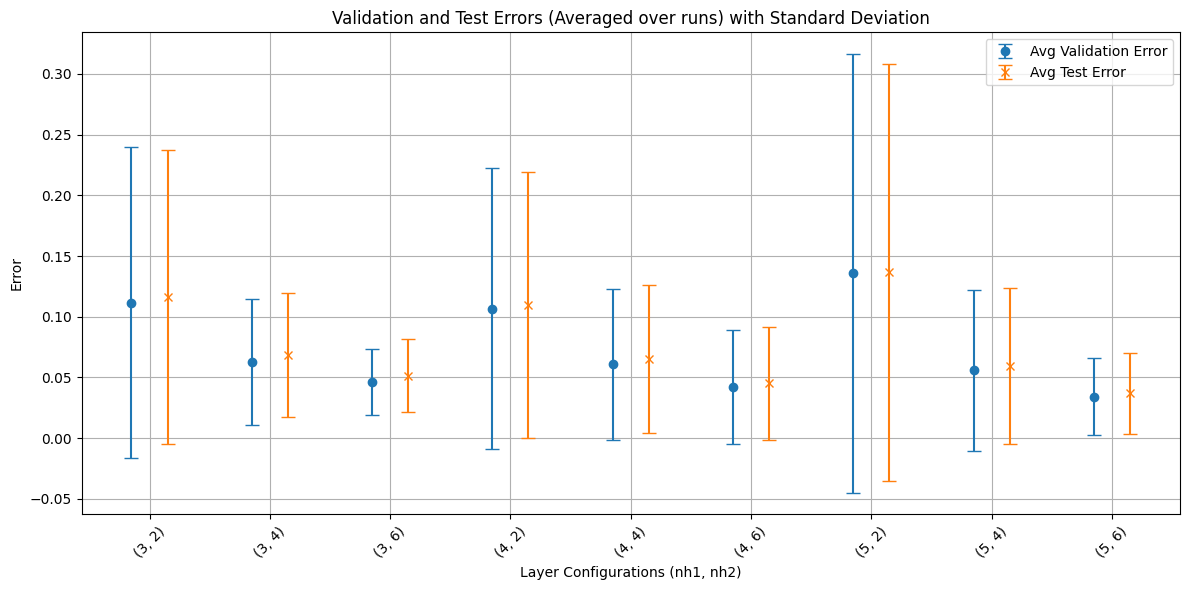

Test error (best run) for the best configuration: 0.007156858220696449
Test error (worst run) for the worst configuration: 0.6412439346313477


In [9]:
layer_configurations = [(i, y) for i in [3, 4, 5] for y in [2, 4, 6]]

best_config, worst_config, best_model, worst_model = train_and_evaluate(train, val, test, layer_configurations, runs=100)


### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.0) ###
Early stopping triggered 0 times for model configuration (4, 3)
Early stopping triggered 1 times for model configuration (4, 6)
Early stopping triggered 1 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.02465892508625984 and std: 0.021162438030949974
Best configuration: (4, 9) with average test error: 0.02771548880264163 and std: 0.024570067130444486
Worst configuration: (4, 3) with average validation error: 0.18663483690470456, and std: 0.2108978036454394
Worst configuration: (4, 3) with average test error: 0.18381915874779226, and std: 0.20064541019412274


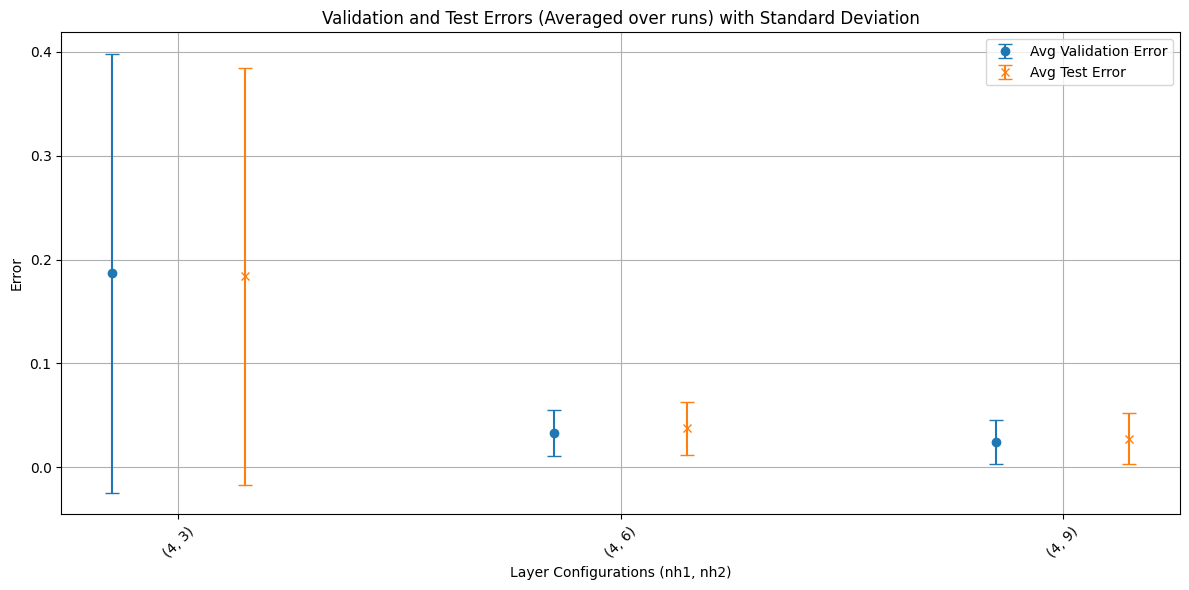

Test error (best run) for the best configuration: 0.014457046054303646
Test error (worst run) for the worst configuration: 0.5135923027992249

### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.01) ###
Early stopping triggered 2 times for model configuration (4, 3)
Early stopping triggered 1 times for model configuration (4, 6)
Early stopping triggered 0 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.02539309421554208 and std: 0.011410397355195754
Best configuration: (4, 9) with average test error: 0.028825032711029052 and std: 0.012736819263561312
Worst configuration: (4, 3) with average validation error: 0.07244812343269587, and std: 0.06741132116777292
Worst configuration: (4, 3) with average test error: 0.07676290394738317, and std: 0.06540184189513641


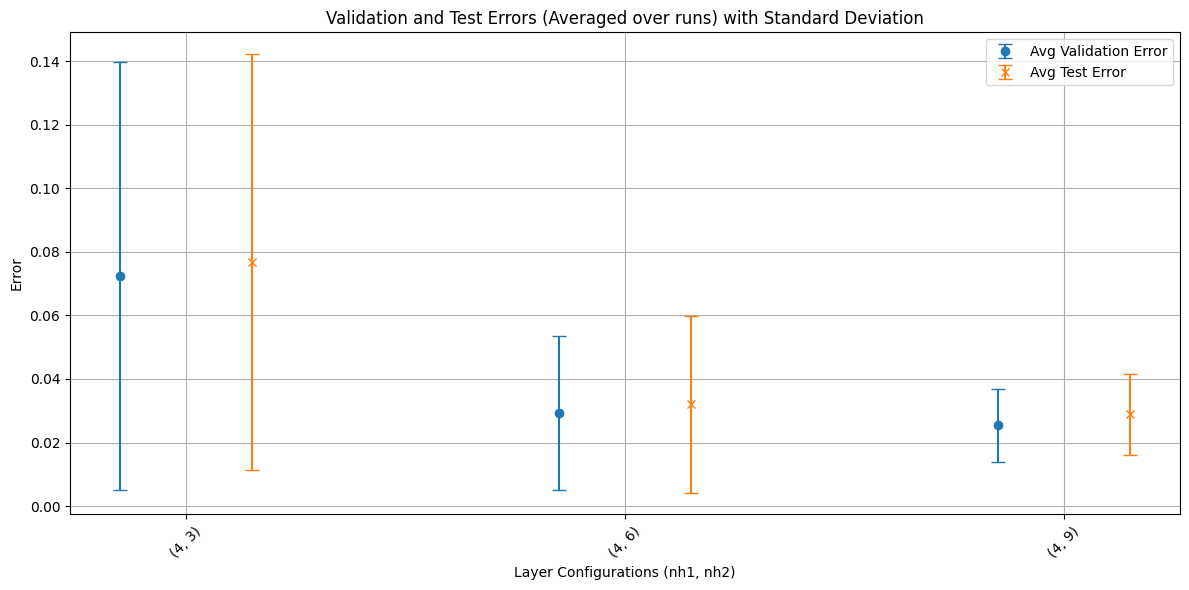

Test error (best run) for the best configuration: 0.01607816480100155
Test error (worst run) for the worst configuration: 0.23232078552246094

### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.1) ###
Early stopping triggered 2 times for model configuration (4, 3)
Early stopping triggered 1 times for model configuration (4, 6)
Early stopping triggered 4 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.06603388600051403 and std: 0.007513935300042921
Best configuration: (4, 9) with average test error: 0.07199295312166214 and std: 0.009554217795436625
Worst configuration: (4, 3) with average validation error: 0.07708021029829978, and std: 0.013588084635624342
Worst configuration: (4, 3) with average test error: 0.0837911382317543, and std: 0.015594105504968066


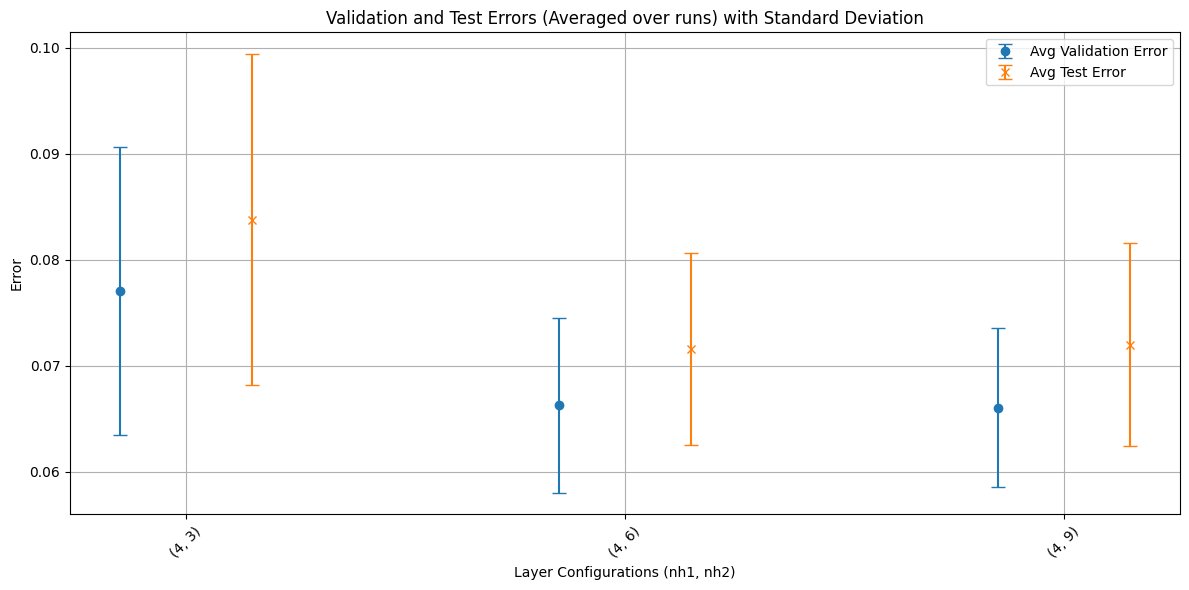

Test error (best run) for the best configuration: 0.05917396396398544
Test error (worst run) for the worst configuration: 0.10977516323328018

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.0) ###
Early stopping triggered 1 times for model configuration (4, 3)
Early stopping triggered 0 times for model configuration (4, 6)
Early stopping triggered 0 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.03879710854962468 and std: 0.028549509870741122
Best configuration: (4, 9) with average test error: 0.041951049491763114 and std: 0.03148855152366076
Worst configuration: (4, 3) with average validation error: 0.065448331926018, and std: 0.06328459768242968
Worst configuration: (4, 3) with average test error: 0.06923521310091019, and std: 0.061127017264131646


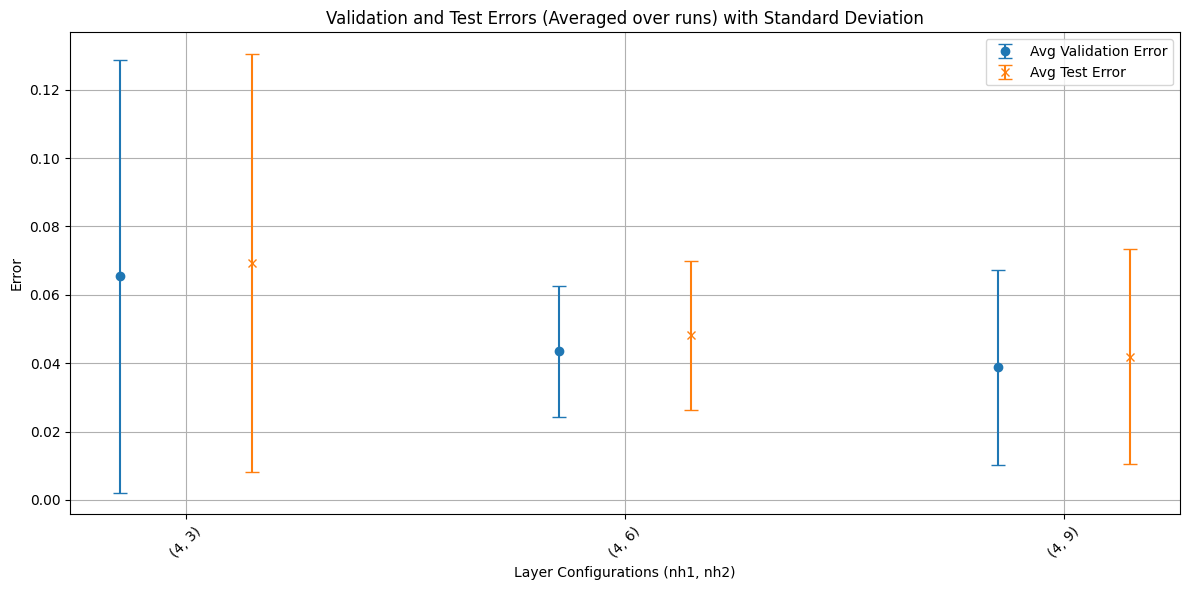

Test error (best run) for the best configuration: 0.008559400215744972
Test error (worst run) for the worst configuration: 0.236622154712677

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.01) ###
Early stopping triggered 0 times for model configuration (4, 3)
Early stopping triggered 1 times for model configuration (4, 6)
Early stopping triggered 0 times for model configuration (4, 9)
Best configuration: (4, 6) with average validation error: 0.0307278411462903 and std: 0.02280472882165339
Best configuration: (4, 6) with average test error: 0.03458910444751382 and std: 0.024783078260478326
Worst configuration: (4, 3) with average validation error: 0.05543287405744195, and std: 0.05315201283099173
Worst configuration: (4, 3) with average test error: 0.057793039921671154, and std: 0.053617502720883524


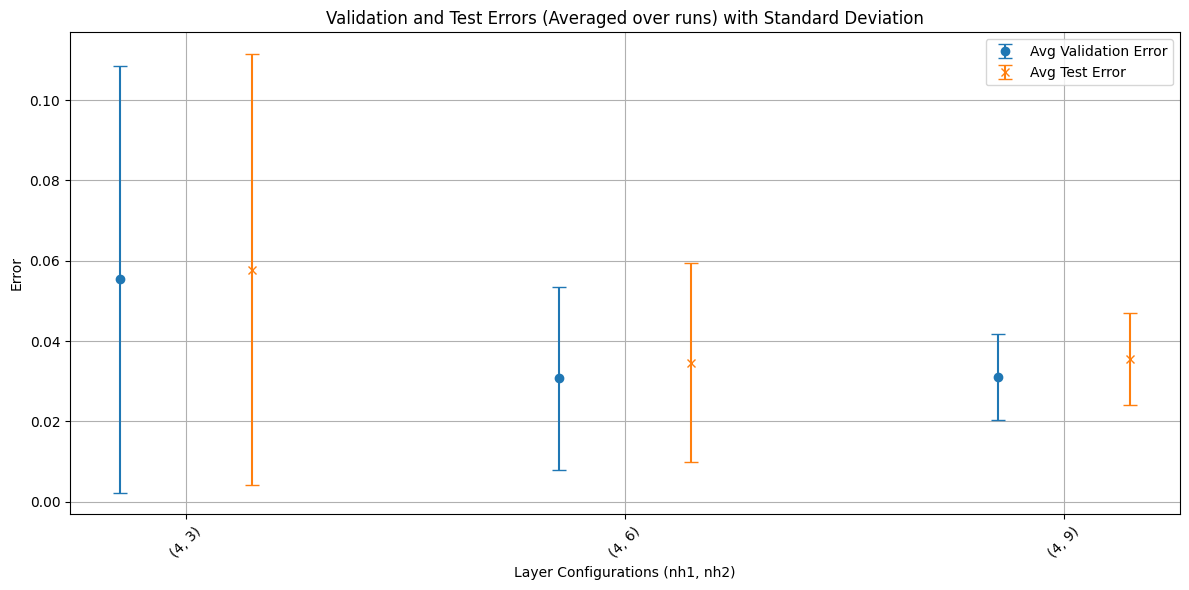

Test error (best run) for the best configuration: 0.014316106215119362
Test error (worst run) for the worst configuration: 0.16274318099021912

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.1) ###
Early stopping triggered 2 times for model configuration (4, 3)
Early stopping triggered 4 times for model configuration (4, 6)
Early stopping triggered 3 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.06052638441324234 and std: 0.005400182795352053
Best configuration: (4, 9) with average test error: 0.06566047444939613 and std: 0.006010764730843637
Worst configuration: (4, 3) with average validation error: 0.13818198069930077, and std: 0.1477346172425237
Worst configuration: (4, 3) with average test error: 0.1417652416974306, and std: 0.13899051778673652


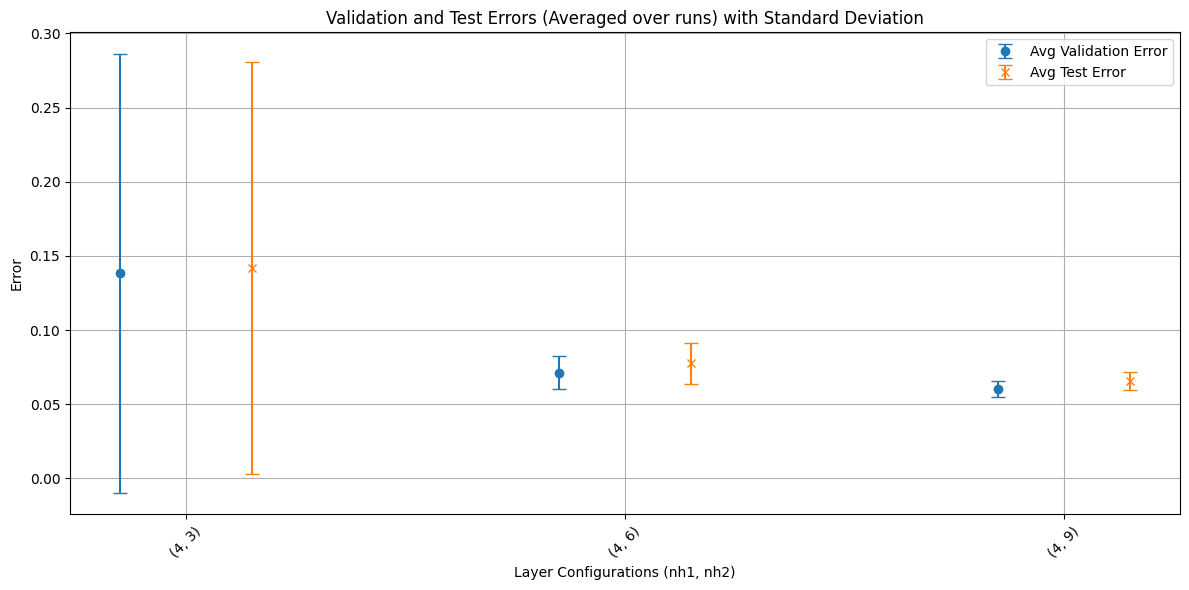

Test error (best run) for the best configuration: 0.05870852991938591
Test error (worst run) for the worst configuration: 0.5391935706138611

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.0) ###
Early stopping triggered 1 times for model configuration (4, 3)
Early stopping triggered 0 times for model configuration (4, 6)
Early stopping triggered 1 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.031176690943539143 and std: 0.022485950331508634
Best configuration: (4, 9) with average test error: 0.034605519380420446 and std: 0.02567706227495028
Worst configuration: (4, 3) with average validation error: 0.06664477810263633, and std: 0.026353498567850228
Worst configuration: (4, 3) with average test error: 0.07350629940629005, and std: 0.028544591606361195


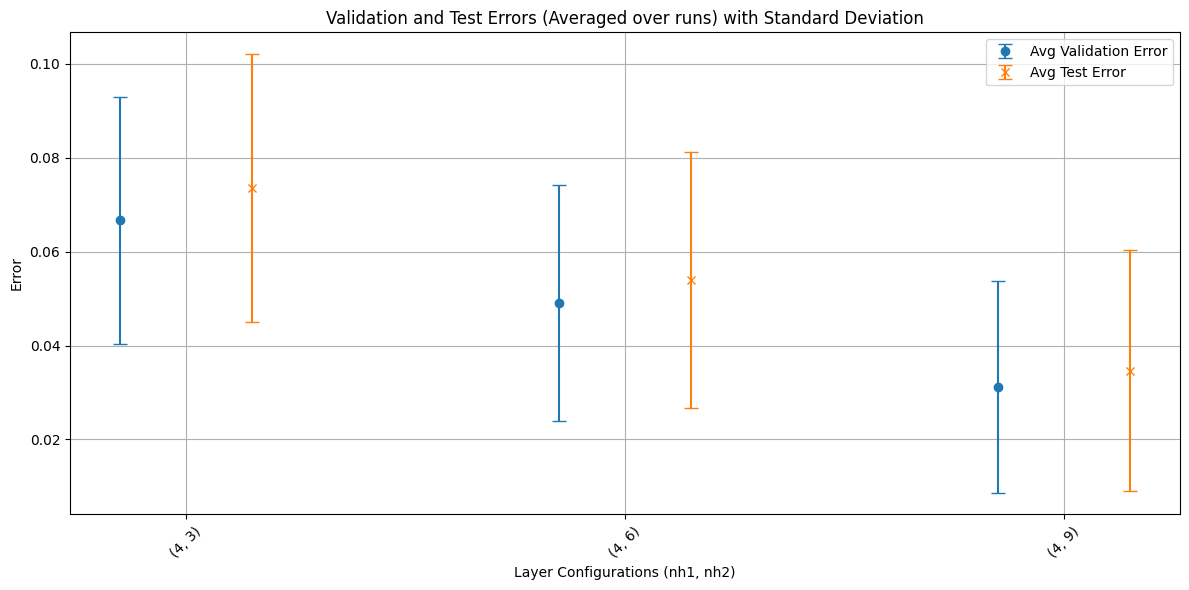

Test error (best run) for the best configuration: 0.008933795616030693
Test error (worst run) for the worst configuration: 0.11445284634828568

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.01) ###
Early stopping triggered 1 times for model configuration (4, 3)
Early stopping triggered 1 times for model configuration (4, 6)
Early stopping triggered 0 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.025321583822369577 and std: 0.014147640094357646
Best configuration: (4, 9) with average test error: 0.02763280589133501 and std: 0.0158667503392792
Worst configuration: (4, 3) with average validation error: 0.06596898296847939, and std: 0.08453144912271313
Worst configuration: (4, 3) with average test error: 0.06932278629392385, and std: 0.08119245598558109


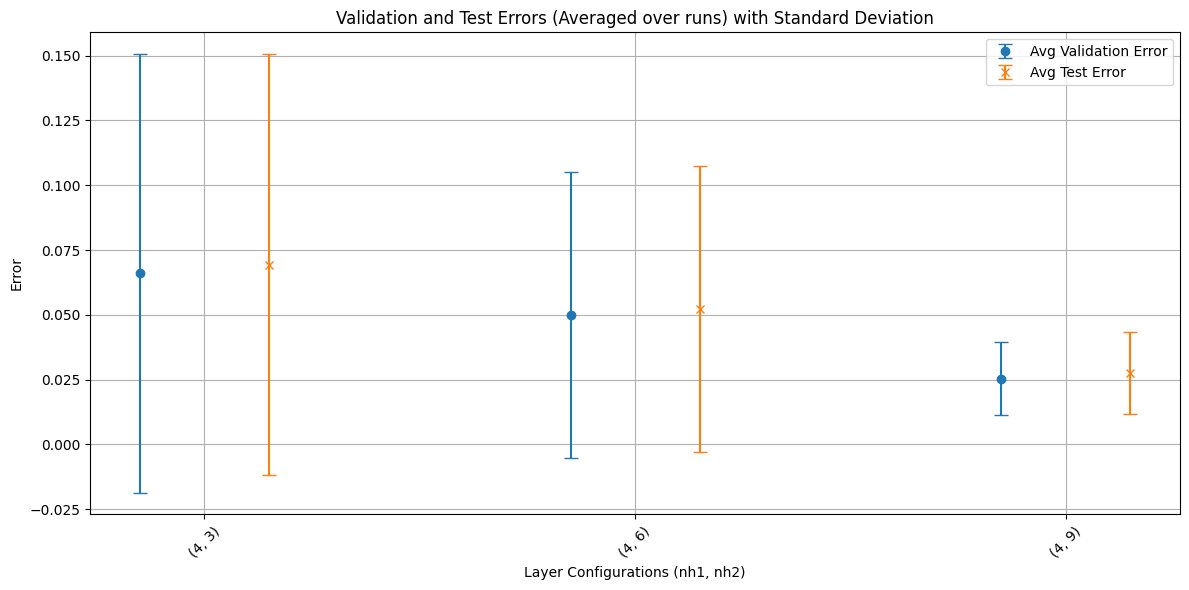

Test error (best run) for the best configuration: 0.018045851960778236
Test error (worst run) for the worst configuration: 0.29972007870674133

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.1) ###
Early stopping triggered 3 times for model configuration (4, 3)
Early stopping triggered 2 times for model configuration (4, 6)
Early stopping triggered 6 times for model configuration (4, 9)
Best configuration: (4, 9) with average validation error: 0.06193024776875973 and std: 0.007820181304063664
Best configuration: (4, 9) with average test error: 0.0671326257288456 and std: 0.00914130228136094
Worst configuration: (4, 3) with average validation error: 0.07386468090116978, and std: 0.015439651227797262
Worst configuration: (4, 3) with average test error: 0.08054458647966385, and std: 0.0172177233763602


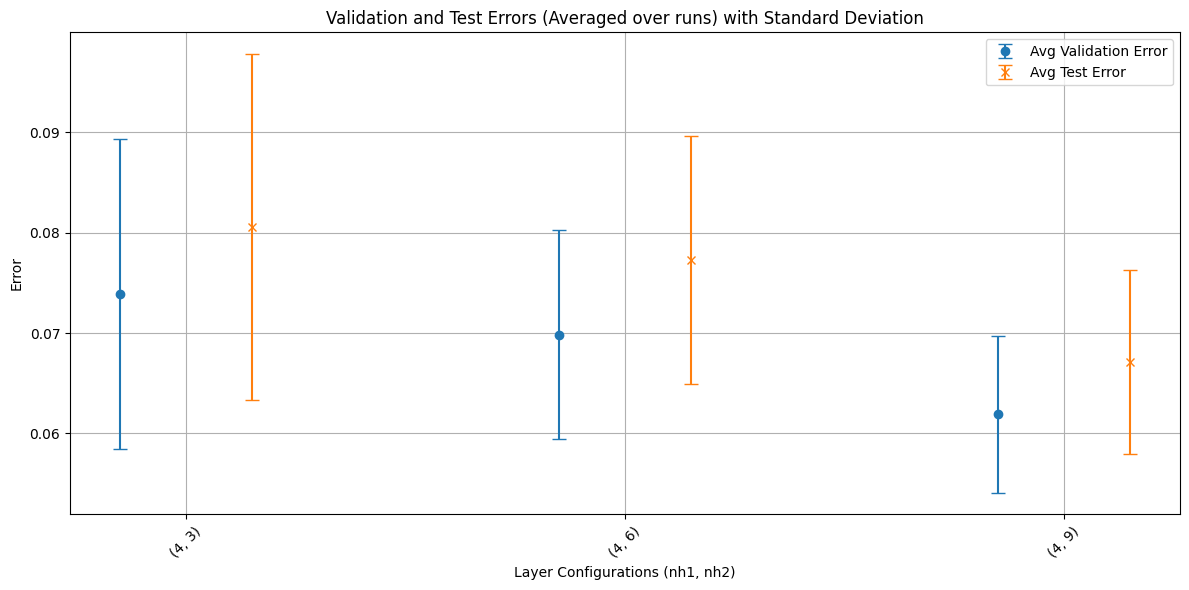

Test error (best run) for the best configuration: 0.054704099893569946
Test error (worst run) for the worst configuration: 0.11337041854858398

Noise Level σ = 0.05, Weight Decay λ = 0.0:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.05, Weight Decay λ = 0.01:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.05, Weight Decay λ = 0.1:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.09, Weight Decay λ = 0.0:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.09, Weight Decay λ = 0.01:
  Best configuration: (4, 6)
  Worst configuration: (4, 3)

Noise Level σ = 0.09, Weight Decay λ = 0.1:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.15, Weight Decay λ = 0.0:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.15, Weight Decay λ = 0.01:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.15,

In [15]:

best_nh1 = best_config[0]
nh2_values = [3, 6, 9]
layer_configurations = [(best_nh1, nh2) for nh2 in nh2_values]

noise_levels = [0.05, 0.09, 0.15]
weight_decay_values = [0.0, 0.01, 0.1]

results = {}
models = {}

for noise_level in noise_levels:
    for weight_decay in weight_decay_values:
        print(f"\n### Evaluating with Gaussian noise (σ = {noise_level}) and weight decay (λ = {weight_decay}) ###")
        
        train_noisy, val_noisy, test_noisy = generate_data(x, noise_std_factor=noise_level)
        
        (best_config_noisy, 
         worst_config_noisy, 
         best_model_noisy, 
         worst_model_noisy) = train_and_evaluate(
            train_noisy, 
            val_noisy, 
            test_noisy, 
            layer_configurations, 
            early_stopping=True,
            weight_decay=weight_decay,
            runs=10  
        )
        
        results[(noise_level, weight_decay)] = {
            "best_config": best_config_noisy,
            "worst_config": worst_config_noisy
        }
        
        models[(noise_level, weight_decay)] = {
            "best_model": best_model_noisy,
            "worst_model": worst_model_noisy
        }

for (noise_level, weight_decay), res in results.items():
    print(f"\nNoise Level σ = {noise_level}, Weight Decay λ = {weight_decay}:")
    print(f"  Best configuration: {res['best_config']}")
    print(f"  Worst configuration: {res['worst_config']}")
